# Compass Walker dynamics

Reference: https://underactuated.mit.edu/simple_legs.html#section2

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/compasswalker/actinf-compasswalker`


In [2]:
using Base64
using LinearAlgebra
using Distributions
using CairoMakie

In [3]:
# Frames per second
fps = 30;

In [4]:
function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
    base64encode(open(read,filename)),"""" type="video/mp4"></video>"""))
end

display_mp4 (generic function with 1 method)

#### Coordinate system

In [5]:
θr = range(0, stop=2π, length=100)

f = Figure(resolution = (800, 500))
ax = Axis(f[1, 1], aspect = 1)
xlims!(-1.1,1.1)
ylims!(-1.1,1.1)

# States
θk = Observable(0.0)

# Stance leg
xr = @lift([cos(-$θk + π/2)])
yr = @lift([sin(-$θk + π/2)])
scatter!(xr, yr, linewidth=5, color=:black)

# Write animation
record(f, "animations/trig.mp4", θr; framerate = fps) do θ
    θk[] = θ
end

display_mp4("animations/trig.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAM7dtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0+ZYiEADf//veBvzLLXyK6yXH5530srM885DxyXs1+HgxQ4gY4IPj10/4jHrGCmU3mpqKGyVfSZsfjJAAAAwAABuAVQ9ijnCp8lLLh1/jbaOKo5QFZKJQaRzHtvxu4Gg6XbAwYcLXFXmbxM6R+//IFehYWwu9lIYKsB52gMiXCEf/dLVn9J2JRPRMQ76zh29W/SjXpy1ceVnC45epub3bn+RIql8uq8IUQvVAvC9vtTnpftuNEXMyxNKs00PwgB3Bd3nWD9xMiocc1jxRRsu5r3UzsvtRp/aRnTawAbuVDrmvjIcVcNf6MN5q9A5nmDDsYb/yt4vvix3pGhIMstP/qWwq/EC4v+UXLIUwG+rk/ZuRm78aI+yNX2NS0gsP5weBj0LIZIsScfxp7dMRDv/q7DDaJALStDDZc0s3e+68qUhm7IpK2noJBfDkTcwtlK6ZyNi9ej7sBMbKanr8NqDJ8aN3vAyvx58GddibcRDIejZI0HKvjC1uKpCEALhQdXqfn9/fATFtH+rXFBb4xOBh633f+/U6hrIrcjB5v3UoqcN9a/5Kt1SYFLwev5fmHPHMArJnahHVme+vAGzdnH5Dii2j8qylqaB5+FtKCHB0mHn2E+DWW0CTEabpQJUbj896zfNExezvX63SPdf8fWl1VWaJD0Amv2YT7lhTRaNBQN9EnqTxooXntoj5lBXgyvLneX/w3RAkcGqLE2dcNQkD/ZXR5YUUnYNsMEiiPecTFk1rTmQL/9YL0j1xnz9CXl2wzagbkkU47Vmovp28vuwAawwIAc86HsvRC+W+FeDq6Z2uOVeBgkQGgB+iRzA6ATxm0AAADAAADACHtkde7CydUP0JonxcAterNO7eKueKOu1M0tVMq2OjcOUof5d2bYzGCxp1n39Ed5h+A/x05rkRgfdAhGVleOiuIwvfEA2juGThxqJ3PPhqa5ajuE8ColQ4Uvkmps2FSERsbuDecRM2eoc9gTdmaG3DN/rNHm6JsI/s2z7604ufF04PTY7X1gk+LvhRMc6RltDtnRZyjXqwFD2OMR7XhnAjAA1dRmCGINE707PnaZeVFo8uNwPvnRtf0jTkzznl7HMsvpV+O9xoKCokpNjjKf2hSfFtATkry7fZm0oubh6m/2OkHab/5KkqPFUKeIgvSGlkeUYZXXNH++7Ch8QqHBCf+HoNWEt9nyaaLPTsGIKJN7L1pNJmc733DKNunaAcLDBWW0E07DEgk2//MEvzWJM/kj0V6j7XiyDGtjIrnvjSH6gz7oHxKpls2bATeOQbyRUn5wRaI5H2CDnpLdwHU+8CBBBudTgaBYRIBPEOvctmGAAb8YAAAAwAAAwAAAwAAAwAAcgzxNmv/3QUSUM3VK50wfbdk0kf9mOkg4OooViVsyxASBl0N0qIRBaz/kb3KJZwRt1f7Bd8qRDHLJ4H/ZnfNjRuaX161S9lCaiZdEGPSwGqDEyY1/XVTsJiJfxJ0+xDw9b2XNi47i7YKyokIlapOZNGwEy9UQTbeRgrJq5/ztf5Gs6p4I/+DSxHVqfIwA+EI2CFiNW7a4+EegJOu/Fqq6mz4NVz6ABUwCoKO8RRWMHHP65USbg2+SE0qJovioiFXKJk7PW5rfH2TEe5k+ZNOIPJvNci53iZpxdWS+2bEGHA/C3vfg2fznqhK9zE+u3kuIidFiGr3ry4o8bU8mUD1D7zR/feT5AAFcAv4KQDZest+OncIvlhpCIcd3+RHD9IigoLQ8FNwSiLGO3801K5iKrWrG9EhIN6nEP2Xb0A1kRUcZyofc9om6R100r0okctlFZdhhSMe2EfAVW/2/qRsT2VBIoAQmv4WHJzF62AAAAMAAAMAAAMAAAMAAHnnHXo0cC3CGFCxwB7OnNDy7jGHPn+MyJYQ0taPZj+GmvemYJtYhvlujquaCpfZ4PV138IMY9bP5A8NImljcDf2EHMUKTOM9xF7UYKLlXge/hZMgGaUiZ3PnmXvYAAEA9+O+ewRt1/Yxx7t9Fv7pqWxvxKXQsYiEruWztUPZTrZljTgv2eLvzvlFJ1a8kD2/hkG+q53r8P14YH7zVaRE4wesDaFf3e9TGawKyzHO2kvNqDlO5CZBO9DOjDuAv5wFChh++QkPNhhqmyDevtcrTiVFxA9l2ackgDfNc4cHPFtFr5knhepdJ4C/G7tEvq1jFUZ07n4CBzZjZ8VvKdGZ//NsFSqVnV/boVAswiYvZVH8ELrexxIqili5KUf9X+4dHrhvmFaha5RVlxuAlqhD/bHP0i2rmv3WgOvYm1g3f7rLkb1Wc612euOjyst3ixwfBu+JFiyFoBEupdTzwALQAAAAwAAAwAAAwAAAwH5mQyobHvP1C8BqrjiQP+LPcy/A1kSB09m+4AA5o1MLPpResZgXvBjaXRsQJAgvxWwU5P2Oj7c6EM+j0hxuSJQN2gBj6LsFeOaRMPjfhq7Fmhdw412HeUn7vop4nkQbKxOFEt6ct5nyutiu4JNog0xl2g0d4W9BpQ0JZy7bWwJlmsiJneJyeD8Ke3znjilrG+DRih0miRm98TdIqpwFBpf9L9SJomFNPO7VUsyfzKprut95U7s+z3RaeTNiESMFTIyJF/1okfcLPt3EV9X7v+zf+Ma120Ezh2VLB6zWQt5xxeNhvIP9rdTXkbeNwe1RQ88ftMbL5XCEUNEkPpjr/lF+tjCVCO65W7ELj8m3xrvZfZ6G8QK6sd4/W6R6CxQU4PnsV0+AAC0aJb5ONewhtoH3LHZWaGR2oGlX3tqgp4svO7v69GRKW5NxzywFuM3EHfbH/rCTK27EWuXeSEkpbAna0pLuKeZHVKkQDlpEAuYvZk54aVIdaM6AeaTA4RXvRKQvdm1KBeK2FoA5whxwqhGEKMHTLpE6sHJ47FaHSPAYEdgUqZJvRrEmPaH0q1ldIW+mvQH+bDL0sRa3vcIDIkUqrXtAQdbcxJAFAmz+ISAHflnZTUW61cdwaC6P6hLLNhIPJo

## System

![](figures/compass_gait.svg)

States of the robot are the angle of the stance leg, $\theta := \theta_{st}$, the angle of the swing leg, $\eta := \theta_{sw}$, and the changes in angles, $\dot{\theta}, \dot{\eta}$.

In [6]:
# Dynamical parameters
m_h = 10.0           # kg
m   = 5.0            # kg
a   = 0.5            # m
b   = 0.5            # m
l   = a + b          # m
γ   = π/8            # radians
cθ  = 10.0            # friction
cη  = 10.0            # friction
const gravity = 9.81 # m/s^2

9.81

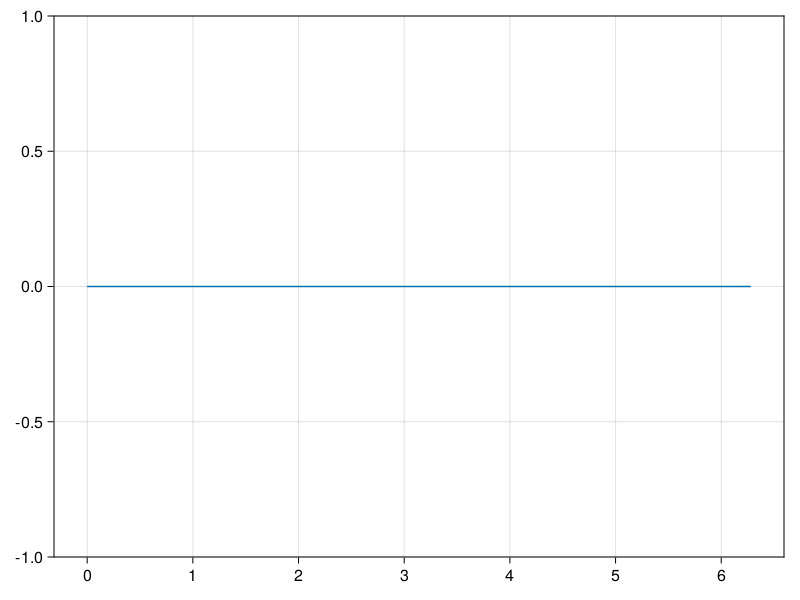

In [7]:
function u(t)
    return 0.0
     # return max(0, sin(t))
end

lines(range(0, stop=2π, step=0.01), t -> u(t))

## Single stance

In [8]:
function dzdt(z,t)
    
    # Unpack state
    θ, η, dθ, dη = z
    
    # Mass matrix
    M = [(m_h+m)*l^2+m*a^2    -m*l*b*cos(θ-η);
          -m*l*b*cos(θ-η)      m*b^2]
    
    # Coriolis matrix
    C = [0                     -m*l*b*sin(θ-η)*dη;
         m*l*b*sin(θ-η)*dθ                      0]
    
    # Gravity terms
    τg = [(m_h*l+m*a+m*l)*gravity*sin(θ)-cθ*dθ; -m*b*gravity*sin(η)-cη*dη]
    
    # Control matrix
    B = [-1, 1]
    
    return [dθ; dη; inv(M)*(-C*[dθ, dη] + τg + B*u(t))]
end

dzdt (generic function with 1 method)

In [9]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

In [10]:
function check_collision(x,y)
    "Check distance to halfplane"
    
    # Normal vector to incline
    nv = [3tan(γ), 3]
    
    # Distance of surface to origin
    db = -dot(nv, [0., 3tan(γ)])
    
    # Check side of halfplane
    return (dot(nv,[x,y]) + db) <= 0.0
end

check_collision (generic function with 1 method)

In [ ]:
function collision(z,t)
    
    # Reduce velocity from impact
    
    return 
end

In [11]:
function angles2end(θ,η)
    xk = contact[1] + l*cos(-θ + π/2) + l*cos(-η + π/2)
    yk = contact[2] + l*sin(-θ + π/2) + l*sin(-η + π/2)
    return [xk,yk]
end

angles2end (generic function with 1 method)

In [12]:
function show_state(θ, η, contact)
    
    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])
    
    # Hip joint
    hipx = contact[1] + l*cos(-θ + π/2)
    hipy = contact[2] + l*sin(-θ + π/2)

    # Stance leg
    xk_st = [contact[1], hipx]
    yk_st = [contact[2], hipy]
    
    # Swing leg
    xk_sw = [hipx, hipx + l*cos(-η + π/2)]
    yk_sw = [hipy, hipy - l*sin(-η + π/2)]
    
    # Visualize
    lines!(xk_st, yk_st, linewidth=5, color=:black)
    lines!(xk_sw, yk_sw, linewidth=5, color=:black)
    CairoMakie.scatter!([hipx], [hipy], marker=:circle, markersize=20, color=:black)
    
    cl =check_collision(xk_sw[2], yk_sw[2]) ? :red : :blue
    scatter!(xk_sw[2], yk_sw[2], markersize=15, color=cl)
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)
    
    return f
end

show_state (generic function with 1 method)

In [13]:
function animwalker(θt::Vector{Vector{Float64}}, contact::Vector{Float64})

    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # States
    θk = Observable(0.0)
    ηk = Observable(0.0)

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])
    
    # Hip joint
    hipx = @lift(contact[1] + l*cos(-$θk + π/2))
    hipy = @lift(contact[2] + l*sin(-$θk + π/2))
    CairoMakie.scatter!(hipx, hipy, marker=:circle, markersize=20, color=:black)

    # Stance leg
    xk_st = @lift([contact[1], $hipx])
    yk_st = @lift([contact[2], $hipy])
    lines!(xk_st, yk_st, linewidth=5, color=:black)
    
    # Swing leg
    xk_swf = @lift($hipx + l*cos(-$ηk + π/2))
    yk_swf = @lift($hipy - l*sin(-$ηk + π/2))
    xk_sw = @lift([$hipx, $xk_swf])
    yk_sw = @lift([$hipy, $yk_swf])
    lines!(xk_sw, yk_sw, linewidth=5, color=:black)
    
    # Swing foot
    cl = @lift(check_collision($xk_swf, $yk_swf) ? :red : :blue)
    scatter!(xk_swf, yk_swf, linewidth=5, color=cl)
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)

    # Write animation
    record(f, "animations/passive-compass-walker.mp4", θt; framerate = fps) do θ
        θk[] = θ[1]
        ηk[] = θ[2]
    end
end

animwalker (generic function with 1 method)

In [14]:
Δt = 0.01
time = range(0, stop=10.0, step=Δt)
T = length(time)

1001

In [15]:
# First contact point
contact0 = [1.5, 3tan(γ)/2]

# Preallocate
z_ = zeros(4,T)

# Initial condition
z_0 = [0.1, 0.1, 0.0, 0.0]
z_kmin1 = z_0

for (n,t) in enumerate(time)
    
    # Forward simulation
    z_[:,n] = z_kmin1 + RK4(z_kmin1, t, Δt)
    z_kmin1 = z_[:,n]
    
end

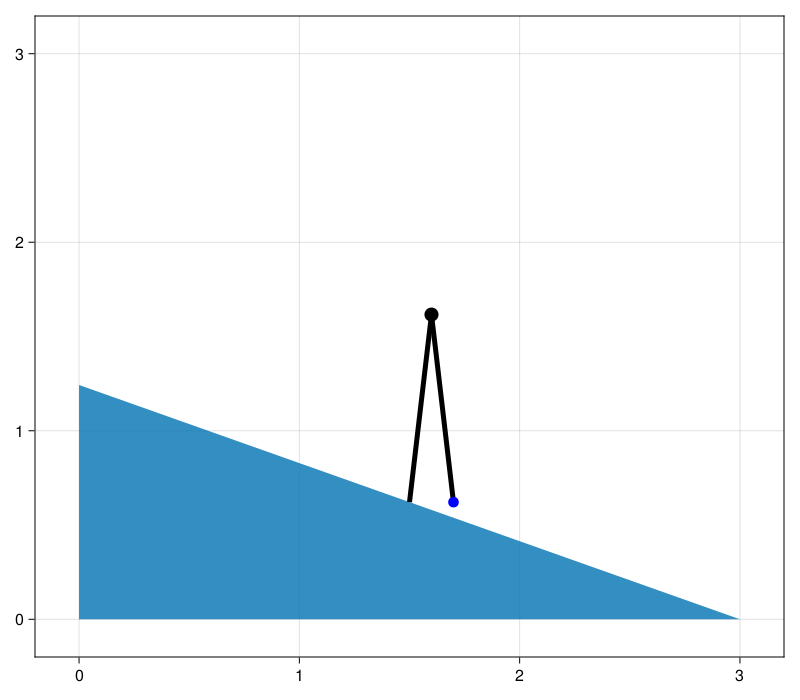

In [16]:
show_state(z_0[1], z_0[2], contact0)

In [17]:
animwalker([z_[1:2,i] for i in 1:T], contact0)

"animations/passive-compass-walker.mp4"

In [18]:
display_mp4("animations/passive-compass-walker.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAC1DZtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABhvZYiEADf//veBvzLLXyK6xl/7hCX/gA8wGEQFmVodKDQAklP0NOAa2Zf1+rkKfwYzAGns4nhcQ4AAAAMAAAMAAAMAN23gR2h2+wbLuXKPuvX8iRmclpG6Pa3f0hJdHRvZ8K5oDRHY2TqX8NgiFcuVshqDIlXMPZ4PJO2L5664oiD0SrqOAzjJT+gHIp8sjdz0wB1MkplpxEyNHJcHZ64YqklEVReq5NiEX8/+65n0dfTwHBFBeCxCUJcgubodHkfkLN+XPkWdv+Fgwph0ORUJJy7ztCJGAbxGqpXExFmAAAXX2doXJsqisiAxniUYcDtMZa2F3EXQeVVVXBbw2yUVjf1BiHoMKyewGo6vssj7sBKXSswtS5AWVdcPENgBfTh6VkUqD1hkwMChWbCCNfJdGD2tM/wEnvfRJYfoAs+DKNMrxVG0iFzM2/f5qCkslidtVt/NsXxiJtP2VQCcwYUFiSGqJm/cktKgb8WyR4n/JcV8jCIjwF0SToT6iEq8fG4LQszm4ko6RCuYTuHE3vw7bzNP4MECSvhQp/vVhL4ACYnDHrSsiSWj3TTM8FBbVoVUnRith8D9F1r8T6Ki8teOb6FCmoJ4I4AAB60AWoBXwIIBDAJsBngUAEZCVHyxsjPJUjb+EvkKlEGcoCusg1gq/GG4GDRzd1fZeHnR8k8IY6hMeUAADQ+I2xkoGFzVjmM54t32snRAqM9xOiU7+5YvimNxXFZH/go8Pet4Ra2ZiHNnpCSH9K6nF0QZx2Ck6SnRGV0Bn9gWQlUcbGkLAW3WB0KnvA2Qq8yP7NduzkEVodSKbz2sE+C7nPgs1cuD+V1XjFcsaKMXWGiaDRUiNoPleb13ZRIwvaDXPkYKnwCQfUlUKOXY/3up9Zh9JUbd2Fpts8gsTJAU9HUOtpR0Akr51q2r0hotFZ+RwAADdgESBVqg8cGMRNL92o0dvtcoqDgABCreaGV1v5b7/k3/xgKwy0dc/VF3rQ7ZmftLIu17ZhytWfYSH3KZrY9zJpaxH8odCXT3spzPcuR6jwtUKa4whkI9uaLmxSmmoEvpNXnjw0CMUT3aYZqQpA2csV52A9nSn8WvyDimedo/3xdLMzY6jvCS11j5dcP5T8cCcBBltffUTLV29A1+fdjKVLD6xMUCASQTzmJyKVJ3CV78IAI8TFzzHEQHsRwpcAuo59QeWORA/42Bmh0yyl7PBZ6qd4Pw6euBBs1O9g9wY0nLp7wqQUHNalliLTztvEhsyGNaO90wKA1qpqvDzL7jf1ebOWdGyr4g235G5WEzKrrEyNObAzPMcAFkBr6OaKtiYwL0Uuh4X1c8rdIGgsfmYh4h9tFwT0q2gqpM4kwvAoCCfW8NtSt5iHT8v++V5TwmQ5afcp+q/6CmJlABJn3YctMXqY6xavPROXtaaXQQ1XOTUiDfZ2P+eqBPRAhC48x9d+Hf3SNYTQcAjzTQADX0c4ZdihI1xZVCY+wDHIMHmtY1loKJQVTbtUDMMp9DNT7yxSLKaKjoA8kvKvNNW/c/MbYBys5xWala2+/25o18Ks8GEWPAdXU3pJfmR4JA1ome+yzb5uk5LuwTOGz7CNiApAQF0KA5LHMtpp0mgHvUcMPbV/cNSD8bXUoqzcm3IFnt3/W9wTKo9D1c7B2cAzpQGo7iEEZ8veNQWpRMXl4eyvqzoZdjoNTZS212aSzWw9L+KYOIHdsAqlies+X7sZ++UH8eofjT1gBMV8rYlZTEz3LGs6kaldb4sG4HNNujyJ2NvDVB+OSii7xgQAnbkjJ7zorbh/lv5SoSqIQeVOecZ27pkDruYAuDstGzZX7KfGxCaxyC4uyZGweEu79kEg6f4hOlO+cNA9RzO68XcMsJr+6cmBwHaNILsN0+X9mqHM6Xd2EBoFXoFz9/BDBsY4XQAw86R+4nmT2r9N/BplNjZPigeR8e30M3enKxrkd8haitxbkK5JiXokq4ARY5KrOAObwK1puU5MBJCCzvMOcYFuSpIZhXRsH1vhHakT/QHtKf4O19qEcIqLTKZQvvIxbzf+EqROCSljfhnA4htfq8Ai+c4W5ej8TIPQ28Cshe3rCxEuVuK4r7/x5rR5Vtcwy9L7MDwVG1ikaGtN1EI26wx8fEp90nzXG4ZHQwxz5K0yzUIzJgmhCz3a3XWtu/6MpRPadgwV0leUY4c9eCxXLchH5unaUP7HMIxHPTVxuhCmQ8jhHVPnnJvffjZ3viB/jaJX/rXpHTWXGZLflltsDmVp3K9GFi/aO/zDL1YqPT5eJH/VhaAGbD1OV0H+/LblV8DDTHD9UKIPATTYAQAI66zfDx0tK3uxGwdps0t1RcjCBrcwHio/ee6yAAAAWXK9cSODtRUbRvoxmPhIGEggtj9ZbTeu6QfMd2fOLYp8HT/gJh6RGvRwDVrZDgvLjskdflUYIU19yup0zodkipjPAX7IuhhxIjYoBbopfVP56YjgOQikRsUTh1Uj6S0R5v19bXrQlZv7/hnhOGlx5MGqoKsmAg9vpdwdpmemGisRAtozSUVXPe/w4sAZ144BM/pxcuEMbvYEZMmMWx6KrWH86W34iprk3XJbC0420yIA6M0a20sgd+0FQ+8IuHq0Q/bN28ckGiM16/PtKVahFxPPHg3/83EQroF0NuktYaQzZxckyVPGzPZF/vsqqQhCdveyjKHK/iDgwHkZZKwLEwPbBdTTVXJt7xvLb8vJTwAXn/cpW9GK6sbkiC+rZBWIR8zwgmUYIje//ePF5YsMY8gqLnUBN/Pu1RXYI5+79h6FJE6+PAagd5PhQQFpTAkAOHydvFmHdIz7syC/BFsPGEWFZl4kl93qw23rW+G6X/vZShdqBSUPsJddxHwKVABLOdIoDbJajJAnnYra3NjDoU+uEfQLyfOwMOhzHc5LDo86itJZf0P1H2vUKyzNMTl2fPPHO3bk7LzF+UtAUzWhwBWirkNaS9w6CEQ5V6Iv+3oeV/lzEdXT7EgsgxS9q